In [1]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
from openpyxl import load_workbook
import re
import io
import os

# basic input ------------------------------------------------
 
def eq_scripts_load(_sep, _subdir, _file):
    
    # if specific file selected it should be XLSX one
    if _file != "":
        
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        _file = _subdir + _file
        
        # open excel file
        with open(_file, "rb") as f:
            inmemory_file = io.BytesIO(f.read())
        wb = load_workbook(inmemory_file, read_only = True)
        
        # read data
        r = re.compile(r'^(input\_)*stoich(iometric)*\_coefficients*$')
        st_coeff_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
        r = re.compile(r'^(input\_)*concentrations*$')
        con_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = 1)
        
        r = re.compile(r'^(input\_)*concentrations*$')
        type_con = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0]
                                 , header = None, nrows = 1).iloc[0,:]
        
        r = re.compile(r'^(input\_)*k\_constants\_log10$')
        lg_k_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
        r = re.compile(r'heats')
        heats_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], index_col = 0)
        
        r = re.compile(r'targets')
        targets = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None)
        
        r = re.compile(r'enthalpies')
        delta_H = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
        r = re.compile(r'^(particle|component)_names*$')
        component_name_for_yields = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0]
                                                  , header = None).iat[0, 0]
        
    # use a bunch of plain text files instead
    else:
          
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        file_names = list(os.listdir(path = _subdir))

        r = re.compile(r'^(input\_)*stoich(iometric)*\_coefficients*')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        st_coeff_data = pd.read_csv(file, sep = _sep)

        r = re.compile(r'^(input\_)*k\_constants\_log10')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        lg_k_data = pd.read_csv(file, sep = _sep, decimal = ",")
        
        r = re.compile(r'^(input\_)*concentrations*')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        con_data = pd.read_csv(file, sep = _sep, decimal = ",", header = 1)
        
        type_con = pd.read_csv(file, sep = _sep, header = None, nrows = 1).iloc[0,:]
        
        r = re.compile(r'heats')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        heats_data = pd.read_csv(file, sep = _sep, decimal = ",", index_col = 0)
        
        r = re.compile(r'targets')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        targets = pd.read_csv(file, sep = _sep, header = None)
        
        r = re.compile(r'enthalpies')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        delta_H = pd.read_csv(file, sep = _sep)
        
        r = re.compile(r'^(particle|component)_names*')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        component_name_for_yields = pd.read_csv(file, header = None).iat[0, 0]

    return st_coeff_data, lg_k_data, con_data, type_con, heats_data, targets, delta_H, component_name_for_yields  

In [2]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np
import re

# basic preprocessing ----------------------------------------
    
def eq_preproc(st_coeff_data, lg_k_data, con_data, type_con, heats_data, targets, delta_H, component_name_for_yields, _calor_setup_type):
    
    # checking if there are several series
    
    if 'series' not in con_data.columns:        
        con_data['series'], type_con[np.shape(st_coeff_data)[1]] = '', ''
    
    if 'series' not in heats_data.index:
        heats_data.loc['series'] = ''
    
    if 'volumes' not in heats_data.index:
        heats_data.loc['volumes'] = 1        

    # series variables
    
    ser_info = con_data['series'].to_numpy()
    ser_unique = np.unique(ser_info)
    ser_num = np.shape(np.unique(ser_info))[0]

    # matrix of stoich coeff with formal reactions added
    st_coeff_matrix = st_coeff_data.drop('name', axis = 1).to_numpy()
    formal_matrix = np.eye(np.shape(st_coeff_matrix)[1], dtype = int)
    st_coeff_matrix = np.vstack((formal_matrix, st_coeff_matrix))
        
    # product names lists : full and base components only
    
    prod_names_con = list(con_data.drop('series', axis = 1))
    prod_names = prod_names_con + st_coeff_data['name'].tolist()
    
    # creating the vector of equilibrium constants including the formal reactions
    lg_k = (np.vstack((np.zeros((np.shape(st_coeff_matrix)[1], 1)), lg_k_data.to_numpy().astype(float))))
    
    # checking the consistency of reagent names in different sheets    
    if prod_names_con != list(st_coeff_data.drop('name', axis = 1)):
        print('Check the consistency of reagent names!')
    
    con_matrix = con_data.drop('series', axis = 1).to_numpy()
    ser_counts = con_data.groupby(['series']).size().tolist();
    
    # creating vector of indices of components with predetermined concentrations
    ign_indices = np.array(type_con.index[type_con == 'eq'])
    
    # reading volumes from experimental data
    volumes = heats_data.loc['volumes'].to_numpy()
    
    # reading exp heats from experimental data
    heats = heats_data.loc['observation'].to_numpy() - heats_data.loc['dilution'].to_numpy()
        
    devs = heats_data.loc['deviation'].to_numpy()
    
    # creating vector of known enthalpies
    dH_par = np.hstack((np.zeros(len(prod_names_con)), np.transpose(delta_H.drop('Reaction', axis = 1).to_numpy())[0]))
    
    # number of constant to find
    tar_names = set(targets.to_numpy()[0][1:])
    tar_num = [index for index, item in enumerate(prod_names) if item in tar_names]
    
    # number of enthalpy to find
    dH_names = np.hstack((prod_names_con, np.transpose(delta_H.drop('Value', axis = 1).to_numpy())[0]))
    un_el = set(prod_names) - set(dH_names)
    dH_ind_wtf = list([index for index, item in enumerate(prod_names) if item in un_el])
    un_el = set(prod_names) - (set(prod_names) - set(dH_names))
    dH_ind = list([index for index, item in enumerate(prod_names) if item in un_el])
    
    if component_name_for_yields not in prod_names:
        print('The component name for partition should be among those of basis components')
        
    idx, = np.where(component_name_for_yields == np.array(prod_names_con))
    
    # creating array of diff total concentrations
    con_matrix_red = [] 
    for s in range(ser_num):
        for k in range(ser_counts[s] - 1):
            con_matrix_red.append(con_matrix[int(np.sum(ser_counts[:s])) + k + 1])
            
    if _calor_setup_type == 'DSC':
        _calor_setup_type_coeff = [[1] for i in range(len(con_matrix_red))]
    
    else:
        _calor_setup_type_coeff = 1 / np.array(con_matrix_red)[:, idx] 
    
    return ser_num, st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, ser_counts, ser_info, type_con, volumes, heats, devs, tar_num, dH_ind, dH_ind_wtf, dH_par, idx, _calor_setup_type_coeff

In [3]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import math
import numpy as np
from copy import copy, deepcopy

def eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices, ser_counts, ser_info): # ser_num, ser_counts, ser_info not further used yet!
    
    c_res_out = [0] * len(con_matrix)
    
    for k in range(np.shape(con_matrix)[0]):
                
        reag_eq_con_matrix = deepcopy(con_matrix[k]) # initial estimation of equilibrium concentrations of reagents
        init_conc = deepcopy(con_matrix[k]) # value for residual calculation in inner function
        
        prod_eq_con_matrix = inner_eq_calc(reag_eq_con_matrix, max_iter, lg_k, st_coeff_matrix, init_conc, ign_indices, eps)   
                    
        c_res_out[k] += prod_eq_con_matrix[0]

    return c_res_out

def inner_eq_calc(reag_eq_con_matrix, max_iter, lg_k, st_coeff_matrix, init_conc, ign_indices, eps): 
    
    lg_k, st_coeff_matrix, con_matrix = deepcopy(lg_k), deepcopy(st_coeff_matrix), deepcopy(init_conc)
    
    # if some equilibrium concentrations are set
    if np.shape(ign_indices)[0] > 0:

        range_start = st_coeff_matrix.shape[1]
        range_end = lg_k.shape[0]
        
        lg_k_upd = np.matmul(st_coeff_matrix[range_start:range_end, ign_indices],
          np.log10(init_conc[ign_indices])) #+ lg_k[range_start:range_end]
        
        lg_k[range_start:range_end] = lg_k_upd.reshape(-1, 1) + lg_k[range_start:range_end]
        
        init_conc = np.delete(init_conc, ign_indices, axis = 0)
        reag_eq_con_matrix = np.delete(reag_eq_con_matrix, ign_indices, axis = 0)
        st_coeff_matrix = np.delete(st_coeff_matrix, ign_indices, axis = 1)

    # start of iterative procedure
    for it in range(max_iter):

        # caclulating the equilibrium concentrations of products
        prod_eq_con_matrix = np.exp(np.transpose(np.array(math.log(10) * np.array(lg_k))) +
                                    np.dot(st_coeff_matrix, np.log(reag_eq_con_matrix)))
            
        # calculating the total concentrations of reagents
        reag_tot_con_matrix_calc = np.transpose(np.dot(np.transpose(st_coeff_matrix), np.transpose(prod_eq_con_matrix)))
            
        # calculating the residuals
        g_res = np.array(reag_tot_con_matrix_calc) - np.array(init_conc)
                            
        # calculating the Jacobi matrices
        jac_matrix = np.dot(np.transpose(st_coeff_matrix), (np.array(st_coeff_matrix) * np.transpose(prod_eq_con_matrix)))   
        
        # new estimation of equilibrium concentrations of reagents
        prev = np.log(reag_eq_con_matrix)
        reag_eq_con_matrix = np.exp(prev - np.transpose(np.dot(np.linalg.inv(jac_matrix), np.transpose(g_res))))
        reag_eq_con_matrix = reag_eq_con_matrix[0]
        error = abs(np.log(reag_eq_con_matrix) - prev)
                
        # checking the convergence
        if np.max(error) < eps:
               
            # if some equilibrium concentrations are set
            if np.shape(ign_indices)[0] > 0:
                prod_eq_con_matrix[:, ign_indices] = con_matrix[ign_indices]
                        
            break

    return prod_eq_con_matrix   

In [4]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np

def enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff):

    # finding the increment in equilibrium concentrations of products - needed for dH calculation
    #import scipy.stats

    dif_conc = [] 
    for s in range(ser_num):
    
        for k in range(ser_counts[s] - 1):
        
            dif_conc.append(c_res_out[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out[int(np.sum(ser_counts[:s])) + k])
               
    # transforming deviation to the matrix form
    devs = np.diag((1 / (np.array(devs) * np.array(devs))) * (np.sum(np.array(devs) * np.array(devs)) / len(devs))) 

    dif_conc, devs, volumes = np.array(dif_conc).astype(np.float32), devs.astype(np.float32), volumes.astype(np.float32)

    # finding vector of experimental values

    q_corr = heats
    for i in range(len(heats)):
        for j in range(len(volumes[dH_ind])):
            q_corr[i] -= volumes[dH_ind[j]] * dif_conc[i, dH_ind[j]] * dH_par[j]

    A = (volumes[dH_ind_wtf] * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff) 
    AT = np.transpose(A)
    LTP = np.linalg.inv(np.dot(np.dot(AT, devs), A))
    RTP = np.dot(np.dot(AT, devs), q_corr)
    dH_res = np.dot(LTP, RTP)
    dH_res_tmp = dH_par

    for i in range(len(dH_ind_wtf)):
        dH_res_tmp = np.insert(dH_res_tmp, dH_ind_wtf[i], dH_res[i])

    dH_res_out = dH_res_tmp

    # calculating st. dev. of dH_res / checking the quality of linear regression

    F_min = 0
    for i in range(len(heats)):
        F_min += (np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i]))  - heats[i]) ** 2

    #disp_0 = F_min / (len(heats) - len(dH_ind_wtf))

    #tn = scipy.stats.t.ppf((1 + 0.95) / 2, len(heats) - len(dH_ind_wtf))

    #disp = []

    #for i in range(len(dH_ind_wtf)):
        #disp.append(disp_0 * LTP[i, i])
    
    return F_min, dH_res_out #disp

In [5]:
# input for xlsx file
_subdir = "calorimetry"
_sep = ";"
_file = "test_1.xlsx"
_calor_setup_type = 'DSC'

max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5

st_coeff_data, lg_k_data, con_data, type_con, heats_data, targets, delta_H, component_name_for_yields = eq_scripts_load(_sep, _subdir, _file)

(ser_num, st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, ser_counts,
 ser_info, type_con, volumes, heats, devs, tar_num, dH_ind, dH_ind_wtf, dH_par, idx, _calor_setup_type_coeff) = eq_preproc(st_coeff_data,
                                                                                             lg_k_data, con_data, type_con,
                                                                                             heats_data, targets, delta_H, 
                                                                                             component_name_for_yields, _calor_setup_type)

lg_k[tar_num] = 3

c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices, ser_counts, ser_info)

F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff)

In [6]:
print('\nStoich coeff data')
print(st_coeff_data)

print('\nlg K')
print(lg_k_data)

print('\nconcentrations')
print(con_data)

print('\ntype con')
print(type_con)

print('\nexperimental data')
print(heats_data)

print('\ntargets')
print(targets)

print('\ndelta_H')
print(delta_H)


Stoich coeff data
   PLP  T3H  name
0    1    1  Comp

lg K
   lg_k
0  5.13

concentrations
         PLP           T3H series
0   0.000797  1.000000e-18       
1   0.000796  9.912290e-05       
2   0.000794  1.979165e-04       
3   0.000793  2.963825e-04       
4   0.000792  3.945225e-04       
5   0.000790  4.923381e-04       
6   0.000789  5.898309e-04       
7   0.000788  6.870025e-04       
8   0.000787  7.838545e-04       
9   0.000785  8.803885e-04       
10  0.000784  9.766060e-04       
11  0.000783  1.072509e-03       
12  0.000781  1.168098e-03       
13  0.000780  1.263375e-03       
14  0.000779  1.358342e-03       
15  0.000778  1.453001e-03       

type con
0    tot
1    tot
3       
Name: 0, dtype: object

experimental data
                     1           2           3            4           5   \
data                                                                       
volumes          15.025       15.05      15.075         15.1      15.125   
observation    0.06995

In [7]:
print('\nSeries')
print(ser_num)
print(ser_counts)
print(ser_info)

print('\nSt coeff matr')
print(st_coeff_matrix)

print('\nprod names')
print(prod_names)
print(prod_names_con)

print('\nconst')
print(lg_k)

print('\nconcentrations')
print(con_matrix)

print(ign_indices)

print('\ntype con')
print(type_con)

print('\nvolumes')
print(volumes)

print('\nheats')
print(heats)

print('\ndeviations')
print(devs)

print('\nwhat to find and what is known')
print(tar_num)
print(dH_ind)
print(dH_ind_wtf)

print('\nenthalpies')
print(dH_par)


Series
1
[16]
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

St coeff matr
[[1 0]
 [0 1]
 [1 1]]

prod names
['PLP', 'T3H', 'Comp']
['PLP', 'T3H']

const
[[0.]
 [0.]
 [3.]]

concentrations
[[7.97022000e-04 1.00000000e-18]
 [7.95695999e-04 9.91228990e-05]
 [7.94374403e-04 1.97916525e-04]
 [7.93057190e-04 2.96382517e-04]
 [7.91744338e-04 3.94522502e-04]
 [7.90435825e-04 4.92338095e-04]
 [7.89131631e-04 5.89830903e-04]
 [7.87831733e-04 6.87002520e-04]
 [7.86536110e-04 7.83854532e-04]
 [7.85244742e-04 8.80388513e-04]
 [7.83957608e-04 9.76606026e-04]
 [7.82674686e-04 1.07250863e-03]
 [7.81395956e-04 1.16809785e-03]
 [7.80121398e-04 1.26337525e-03]
 [7.78850991e-04 1.35834233e-03]
 [7.77584715e-04 1.45300060e-03]]
[]

type con
0    tot
1    tot
3       
Name: 0, dtype: object

volumes
[15.024997 15.049994 15.074991 15.099988 15.124985 15.149982 15.174979
 15.199976 15.224973 15.24997 15.274967 15.299964 15.324961 15.349958
 15.374955]

heats
[0.071904538 0.067041971 0.07003089 0.0709173

In [8]:
print('\nEq conc')
print(np.array(c_res_out))
print(np.shape(c_res_out))


Eq conc
[[7.97022000e-04 5.56476215e-19 4.43523786e-19]
 [7.53114141e-04 5.65410413e-05 4.25818578e-05]
 [7.12059319e-04 1.15601442e-04 8.23150839e-05]
 [6.73751452e-04 1.77076780e-04 1.19305738e-04]
 [6.38068057e-04 2.40846221e-04 1.53676281e-04]
 [6.04874437e-04 3.06776707e-04 1.85561388e-04]
 [5.74027838e-04 3.74727111e-04 2.15103793e-04]
 [5.45381319e-04 4.44552107e-04 2.42450415e-04]
 [5.18787162e-04 5.16105584e-04 2.67748951e-04]
 [4.94099713e-04 5.89243482e-04 2.91145036e-04]
 [4.71177635e-04 6.63826048e-04 3.12779988e-04]
 [4.49885580e-04 7.39719506e-04 3.32789139e-04]
 [4.30095343e-04 8.16797213e-04 3.51300678e-04]
 [4.11686517e-04 8.94940365e-04 3.68434881e-04]
 [3.94547037e-04 9.74038371e-04 3.84303954e-04]
 [3.78572991e-04 1.05398888e-03 3.99011723e-04]]
(16, 3)


In [9]:
print(F_min)
print(dH_res_out)

0.00567678197166167
[0.0 0.0 103.12555602054617]


In [10]:
# HOOK-JEEVES PROCEDURE

obj_F = [0] * 3
obj_F[0] = F_min

for j in range(len(tar_num)):
        
    # exploratory_move
    for i in range(max_iter):
        print(i)
        print(obj_F)
        print(lg_k)
        lg_k[tar_num[j]] += step_init
        
        c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
        con_matrix, ign_indices, ser_counts, ser_info)
        
        F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff)
        
        obj_F[1] = F_min
        
        if obj_F[1] > obj_F[0]:
            
            lg_k[tar_num[j]] -= 2 * step_init
            
            c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
                con_matrix, ign_indices, ser_counts, ser_info)
        
            F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff)
        
            obj_F[2] = F_min
            
            if obj_F[2] >= obj_F[0]:
                
                step_init /= 2
                if step_init < HJ_eps:
                    break
                    
            else:
                    
                lg_k[tar_num[j]] -= step_init
                obj_F[0] = obj_F[2]
                
        else:
                
            lg_k[tar_num[j]] += step_init
            obj_F[0] = obj_F[1]

0
[0.00567678197166167, 0, 0]
[[0.]
 [0.]
 [3.]]
1
[0.0032419045719996142, 0.0032419045719996142, 0]
[[0.]
 [0.]
 [4.]]
2
[0.00041852024434688753, 0.00041852024434688753, 0]
[[0.]
 [0.]
 [5.]]
3
[0.00016357966689789017, 0.00016357966689789017, 0]
[[0.]
 [0.]
 [6.]]
4
[0.00016357966689789017, 0.0007647629763070088, 0.00016357966689789017]
[[0. ]
 [0. ]
 [5.5]]
5
[7.450764506521718e-05, 0.00029748505281800973, 7.450764506521718e-05]
[[0.]
 [0.]
 [5.]]
6
[7.450764506521718e-05, 7.450764506521718e-05, 7.450764506521718e-05]
[[0. ]
 [0. ]
 [5.5]]
7
[7.450764506521718e-05, 0.00029748505281800973, 7.450764506521718e-05]
[[0.  ]
 [0.  ]
 [5.25]]
8
[5.6412093326913324e-05, 0.00011164769748856672, 5.6412093326913324e-05]
[[0.]
 [0.]
 [5.]]
9
[5.6412093326913324e-05, 5.6412093326913324e-05, 5.6412093326913324e-05]
[[0.  ]
 [0.  ]
 [5.25]]
10
[5.6412093326913324e-05, 0.00011164769748856672, 5.6412093326913324e-05]
[[0.   ]
 [0.   ]
 [5.125]]
11
[5.595647921146202e-05, 6.279504903577967e-05, 5.5956

In [11]:
print('\nlg K')
print(lg_k)

print('\nF_min')
print(F_min)

print('\nFinal enthalpies')
print(dH_res_out)


lg K
[[0.       ]
 [0.       ]
 [5.0880127]]

F_min
5.538750313855038e-05

Final enthalpies
[0.0 0.0 47.763699152734546]


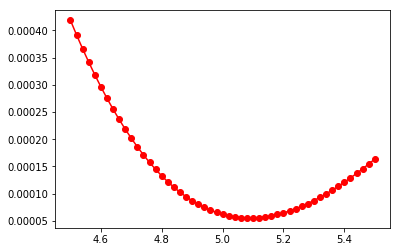

In [17]:
import matplotlib.pyplot

s = 4.5

xxx = []
FFF = []
while s < 5.5:
    lg_k[tar_num] = s
    
    c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
        con_matrix, ign_indices, ser_counts, ser_info)
        
    F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff)
    
    xxx.append(s)
    FFF.append(F_min)
    s += 0.02


matplotlib.pyplot.plot(xxx, FFF, 'ro-')